### Importation des librairies

In [1]:
from math import *
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import uniform
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

### Codes préliminaires

La fonction prior_sample permet de générer les paramètres d'une loi alpha-stable selon des lois uniformes

In [2]:
def prior_sample(seed):
    # Sample from prior distribution
    # For univariate alpha-stable models, sample each parameter from its respective uniform distribution
    np.random.seed(seed)
    alpha = uniform.rvs(1.1, 0.9)  # U[1.1, 2]
    beta = uniform.rvs(-1, 2)  # U[-1, 1]
    gamma = uniform.rvs(0, 300)  # U[0, 300]
    delta = uniform.rvs(-300, 600)  # U[-300, 300]
    return [alpha, beta, gamma, delta]

La fonction univ_alpha_sampler correspond à la simulation de alpha-univariate data décrite dans l'appendix A de l'article de G.W. Peters, S.A. Sisson
, Y. Fan (2012)

In [3]:
def univ_alpha_stable_sampler(params,size,seed) :
    alpha,beta,gamma,delta = params[0],params[1],params[2],params[3]
    #print(alpha,beta,gamma,delta)
    y_bar = 0
    np.random.seed(seed)
    w = np.random.standard_exponential(size=size)
    u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = size)
    if alpha == 1 :
        y_bar = (2/np.pi)*((np.pi/2+beta*u)*np.tan(u)-beta*np.log((np.pi/2*w*np.cos(u))/(np.pi/2+beta*u)))
        return gamma*y_bar + delta
    else :
        S = (1+(beta**2)*(np.tan(np.pi*alpha/2)**2))**(1/(2*alpha))
        B = (1/alpha)*np.arctan(beta*np.tan(np.pi*alpha/2))
        z = np.cos(u-alpha*(u+B))/w
        y_bar = (S*(np.sin((alpha)*(u+B)))*np.sign(z)*(np.abs(z)**((1-alpha)/alpha)))/(np.cos(u)**(1/alpha))
        return gamma*y_bar + delta

On définit ci-dessous la loi à priori de theta qui est une loi uniforme sur les paramètres alpha, beta, gamma, delta.

In [4]:
def prior(theta):
    if 1.1 <= theta[0] <= 2.0 and -1 <= theta[1] <=1 and 0 <= theta[2] <= 300 and -300 <= theta[3] <= 300:
        return 1
    else:
        return 0

On choisit pour le proposal q une loi multivariate_normal dont la covariance est np.diag([0.25, 0.25, 1, 1]) comme cela est indiqué dans l'article de Peters et all. 
Cette loi est bien symétrique, ce qui va permettre de simplifier les calculs par la suite.

In [71]:
def transition(theta, cov):
    return theta+multivariate_normal(mean=[0,0,0,0], cov=cov).rvs()

### Choix de la statistique

On choisit la statistique S1 de l'article de Peters et all car elle semble la plus efficace. Utiliser une statistique permet de réduire la complexité des calculs.

In [6]:
gamma = 10
def compute_quantiles(data):
    # Compute quantile-based summary statistics
    quantiles = np.percentile(data, [5, 25, 50, 75, 95])
    v_alpha = (quantiles[4] - quantiles[0]) / (quantiles[3] - quantiles[1])
    v_beta = (quantiles[4] + quantiles[0] - 2 * quantiles[2]) / (quantiles[4] - quantiles[0])
    v_gamma = (quantiles[3] - quantiles[1]) / gamma
    return v_alpha, v_beta, v_gamma

In [7]:
def S(data):
    # Compute summary statistics of the data
    # This function should return low-dimensional summary statistics S(data)
    # For univariate alpha-stable models, use quantile-based estimators along with the mean of the data
    v_alpha, v_beta, v_gamma = compute_quantiles(data)
    mean_x = np.mean(data)
    return np.array([v_alpha, v_beta, v_gamma, mean_x])

### Noyau gaussien

Comme dans l'article de Peters and all, on définit pour $\epsilon$ tendant vers 0 un noyau gaussien $K_{\epsilon}$ tel que $S(x) \sim \mathbb{N}(S(y), \epsilon^{2}\hat{\Sigma})$ où où $\hat{\Sigma}$ est un estimateur de $cov(S(x)| \theta^{*})$ basé sur $x^{1},...,x^{1000} \sim \pi(.|\hat{\theta})$.

In [8]:
def sigma_hat(theta_hat, size, n_draws = 1000):
    x = np.array([univ_alpha_stable_sampler(theta_hat, size=size, seed=None) for _ in range(n_draws)])
    sumary_statistics = np.array([S(x_i) for x_i in x])
    return np.cov(sumary_statistics, rowvar=False)

In [74]:
def K(u, sigma) :
    d = sigma.shape[0]
    #print(d)
    return -(u.T@np.linalg.inv(sigma)@u)/2-0.5*np.log(2*np.pi)*d-0.5*(np.log(np.linalg.det(sigma)))

### Algorithme MCMC

#### Pseudo code

On s'inspire ici des algorithmes préentés par Marjoram, 20003 et par Cao, Zhang, Zhou, 2024.

(i) On simule $ \theta^{*} \sim q(.| \theta_{n}). $\
(ii) On simule  $ x^{*} = ((x^{*})_{1},... ,(x^{*})_{T}) $ selon $ p(.|\theta^{*}). $\
(iii) On accepte si $ (\theta_{n+1}, x_{n+1}) = (\theta^{*} , x^{*} ) $\ avec la probabilité   $ h = min(1, \frac{\pi(\theta^{*} )q(\theta_{n} | \theta^{*} )K_{\epsilon}(\Delta(x^{*},y))}{\pi(\theta_{n})q(\theta^{*} | \theta_{n})  K_{\epsilon}(\Delta(x_{n}, y))} ) $\
(iv) Sinon $ (\theta_{n+1}, x_{n+1}) = (\theta_{n}, x_{n}) $\

Comme le proposal choisi est symétrique, la probabilité peut se simplifier $ h = min(1, \frac{\pi(\theta^{*} )K_{\epsilon}(\Delta(x^{*},y))}{\pi(\theta_{n}) K_{\epsilon}(\Delta(x_{n}, y))} ) $



In [24]:
# Choix des paramètres à estimer (ils correspondent à ceux utilisés dans l'article de Peters et all). 
#D'après l'article, l'algorithme MCMC marche mieux pour ces paramètres que pour d'autres.
alpha = 1.7
beta = 0.9
gamma = 10
delta = 10

def MCMC(N, size, covariance=np.diag([0.25, 0.25, 1, 1]), seed=42):
    epsilons = [1000-0.01*k for k in range(100000)]                      # epsilon tendant vers 0
    y = levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=size)   # données observées d'une loi alpha-stable
    theta0 = prior_sample(seed)                           # simulation du theta initial avec prior_sample
    thetas = [theta0] * N
    weights = []
    x = levy_stable.rvs(theta0[0], theta0[1], loc=theta0[2], scale=np.abs(theta0[3]), size=size)       # simulation des données suivant p(.|theta)
    sigma0 = sigma_hat(theta0, size=size, n_draws = 1000)
    weights.append(K((S(x)-S(y))/epsilons[0], sigma0))
    n = 0
    n_accepted = 0
    while n<N-1:
        theta = np.array(thetas[n])
        theta_new = transition(theta, cov=covariance)
        prior_new = prior(theta_new)
        # Calcul de la probabilité de rejet h
        h = 0
        if prior_new != 0:
            x_new = levy_stable.rvs(theta_new[0], theta_new[1], loc=theta_new[2], scale=np.abs(theta_new[3]), size=size)    # simulation des données suivant p(.|theta_new)
            sigma = sigma_hat(theta_new, size=size, n_draws = 1000)
            epsilon = epsilons[n]
            w = K((S(x_new)-S(y))/epsilon, sigma)
            h = min(1, np.exp(w-weights[-1]))
        u = np.random.uniform(0.0, 1.0)
        if u < h :
            n_accepted += 1
            thetas[n+1] = theta_new
            weights.append(K((S(x_new)-S(y))/epsilons[n+1], sigma))
        else:
            thetas[n+1] = theta
        n += 1
    rate = n_accepted/N                  # taux d'acceptation
    return thetas, rate

In [25]:
thetas1, rate1= MCMC(N=100000, size=1000)

In [30]:
thetas = thetas1
rate = rate1

### Résultats

La faible convergence de $\epsilon$ contraint à choisir un nombre élevé de burnin (10 000 dans l'article de Peter et all). Il aurait fallu les faire décroître plus rapidement pour améliorer l'algorithme.

In [63]:
alphas = [theta[0] for theta in thetas[60000:]]
betas = [theta[1] for theta in thetas[60000:]]
gammas = [theta[2] for theta in thetas[60000:]]
deltas = [theta[3] for theta in thetas[60000:]]

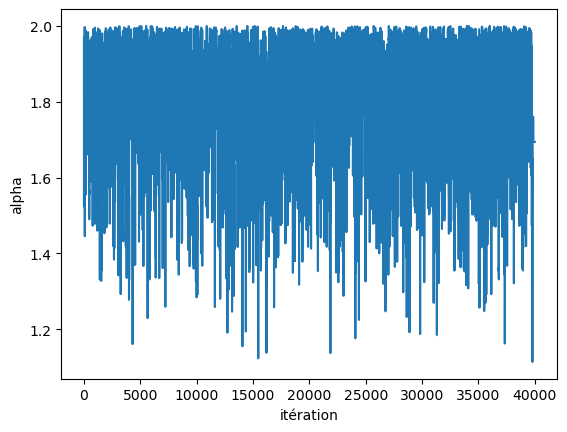

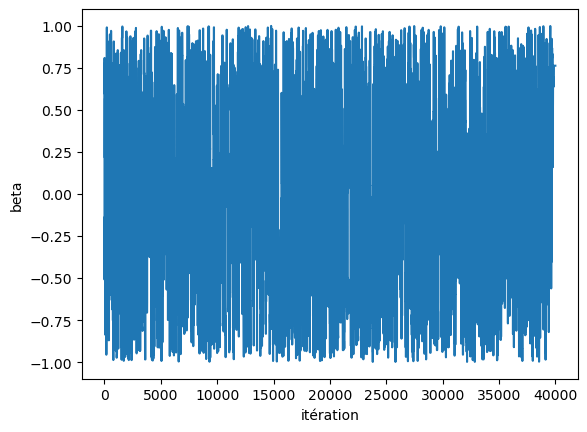

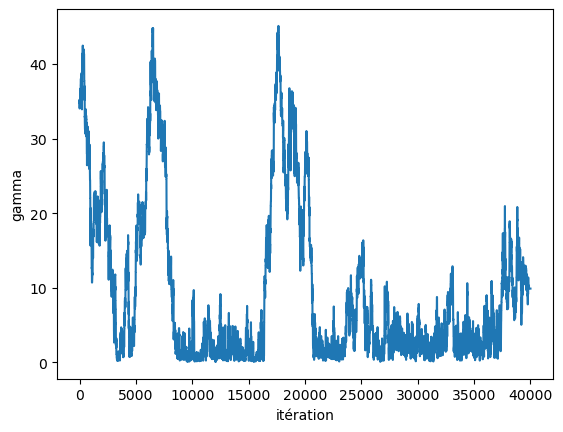

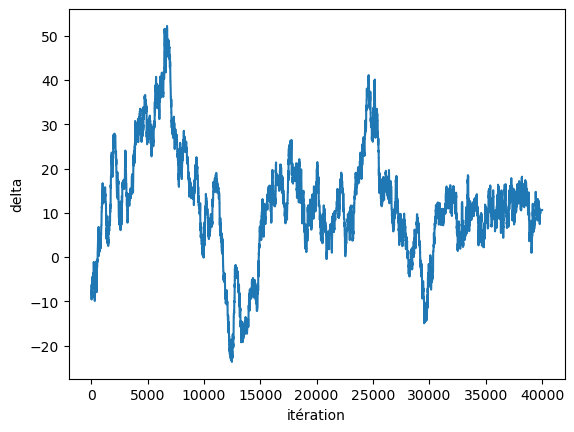

In [64]:
#On trace les estimateurs MMSE de alpha, beta, gamma et delta
n = np.linspace(0, 40000, 40000)

plt.plot(n, alphas)
plt.xlabel('itération')
plt.ylabel('alpha')
plt.show()

plt.plot(n, betas)
plt.xlabel('itération')
plt.ylabel('beta')
plt.show()

plt.plot(n, gammas)
plt.xlabel('itération')
plt.ylabel('gamma')
plt.show()

plt.plot(n, deltas)
plt.xlabel('itération')
plt.ylabel('delta')
plt.show()

In [76]:
# Estimation of parameters

alpha_hat = np.mean(alphas)
beta_hat = np.mean(betas)
gamma_hat = np.mean(gammas)
delta_hat = np.mean(deltas)

print('Estimateur de alpha:' , alpha_hat)
print('Estimateur de beta:' , beta_hat)
print('Estimateur de gamma:' , gamma_hat)
print('Estimateur de delta:' , delta_hat)

Estimateur de alpha: 1.8258098218173866
Estimateur de beta: 0.01577862390082706
Estimateur de gamma: 9.440643649507724
Estimateur de delta: 11.846692420476382


In [80]:
# Root Mean squared error

y = levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=1000)
y_hat = levy_stable.rvs(alpha_hat, beta_hat, loc=gamma_hat, scale=delta_hat, size=1000)
MSE = np.sum((y-y_hat)**2/1000)
RMSE = np.sqrt(MSE)

print(RMSE)

32.96045408144649


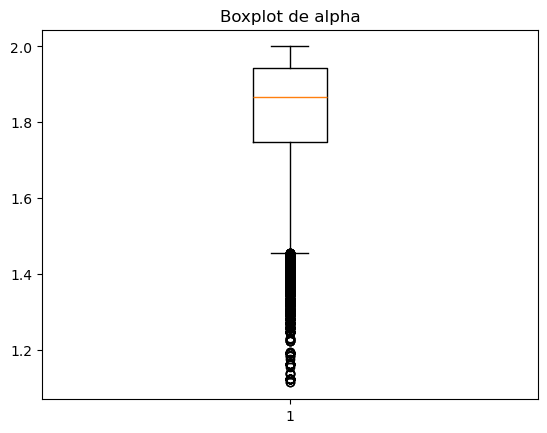

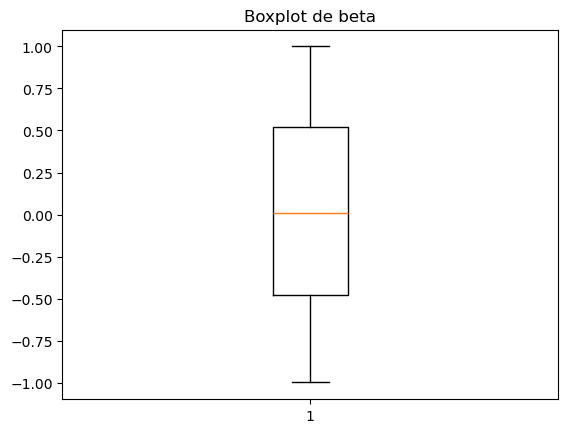

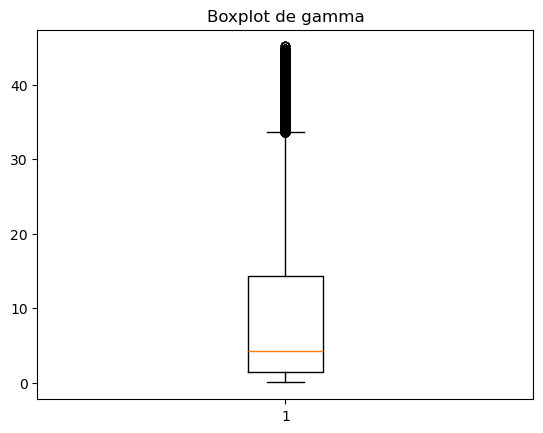

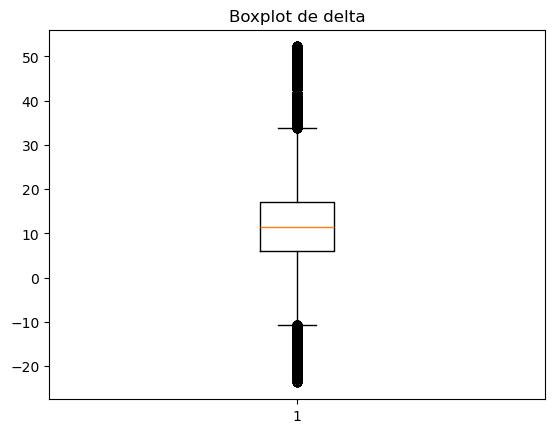

In [78]:
plt.boxplot(alphas)
plt.title('Boxplot de alpha')
plt.show()

plt.boxplot(betas)
plt.title('Boxplot de beta')
plt.show()

plt.boxplot(gammas)
plt.title('Boxplot de gamma')
plt.show()

plt.boxplot(deltas)
plt.title('Boxplot de delta')
plt.show()

In [83]:
# Comparaison des distributions alpha-stable simulée et estimée

y = levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=200)
y_hat = levy_stable.rvs(alpha_hat, beta_hat, loc=gamma_hat, scale=delta_hat, size=200)
plt.plot(y, label='y')
plt.plot(y_hat, label='y_hat')
plt.title('Posterior 
plt.legend()
plt.show()

SyntaxError: '(' was never closed (3233997797.py, line 7)